# Fine Tuning

### Training

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import random
import tensorflow as tf
from IPython.display import clear_output
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification

clear_output(wait=False)

In [12]:
from pathlib import Path

def read_imdb_split(split_dir, min_range):
    split_dir = Path(split_dir)
    texts = []
    labels = []
    for label_dir in ["upselling", "not_upselling"]:
        count=0
        for text_file in (split_dir/label_dir).iterdir():
            if str(text_file).endswith(".txt"):
                count+=1
                text = text_file.read_text()
                text = "".join([i for i in text if i.isalpha() or i==" "])
                texts.append(text)
                if label_dir == "upselling":
                    labels.append(0)
                elif label_dir == "not_upselling":
                    labels.append(1)
                    
                if count==min_range:
                    break

    return texts, labels

training_sentences, training_labels = read_imdb_split("upselling_masked_data/training", 523)
validation_sentences, validation_labels = read_imdb_split("upselling_masked_data/validation", 120)

In [13]:
shuffle_train_sent = list(zip(training_sentences, training_labels))
random.shuffle(shuffle_train_sent)
training_sentences, training_labels = zip(*shuffle_train_sent)
training_sentences = list(training_sentences)
training_labels = list(training_labels)

shuffle_val_sent = list(zip(validation_sentences, validation_labels))
random.shuffle(shuffle_val_sent)
validation_sentences, validation_labels = zip(*shuffle_val_sent)
validation_sentences = list(validation_sentences)
validation_labels = list(validation_labels)

In [14]:
print(len(training_sentences),len(validation_sentences))

1046 219


In [8]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [6]:
train_encodings = tokenizer(training_sentences,
                            truncation=True,
                            padding=True)
val_encodings = tokenizer(validation_sentences,
                            truncation=True,
                            padding=True)

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    training_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    validation_labels
))

clear_output(wait=False)

In [8]:
# We classify two labels in this example. In case of multiclass 
# classification, adjust num_labels value
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
clear_output(wait=False)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

2023-04-13 21:12:13.325026: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5625815040 exceeds 10% of free system memory.
2023-04-13 21:12:16.756331: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.
2023-04-13 21:12:17.005115: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.
2023-04-13 21:12:17.482254: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.
2023-04-13 21:12:17.719537: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.


66/66 [==============================] - 79s 1s/step - loss: 0.5153 - accuracy: 0.7469 - val_loss: 0.2636 - val_accuracy: 0.9041
Epoch 2/20
66/66 [==============================] - 67s 1s/step - loss: 0.1764 - accuracy: 0.9351 - val_loss: 0.0985 - val_accuracy: 0.9726
Epoch 3/20
66/66 [==============================] - 68s 1s/step - loss: 0.0763 - accuracy: 0.9761 - val_loss: 0.0766 - val_accuracy: 0.9726
Epoch 4/20
66/66 [==============================] - 68s 1s/step - loss: 0.0355 - accuracy: 0.9876 - val_loss: 0.0916 - val_accuracy: 0.9772
Epoch 5/20
66/66 [==============================] - 68s 1s/step - loss: 0.0507 - accuracy: 0.9828 - val_loss: 0.1092 - val_accuracy: 0.9635
Epoch 6/20
66/66 [==============================] - 67s 1s/step - loss: 0.0418 - accuracy: 0.9885 - val_loss: 0.1111 - val_accuracy: 0.9726
Epoch 7/20
66/66 [==============================] - 67s 1s/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 0.1057 - val_accuracy: 0.9680
Epoch 8/20
66/66 [=============

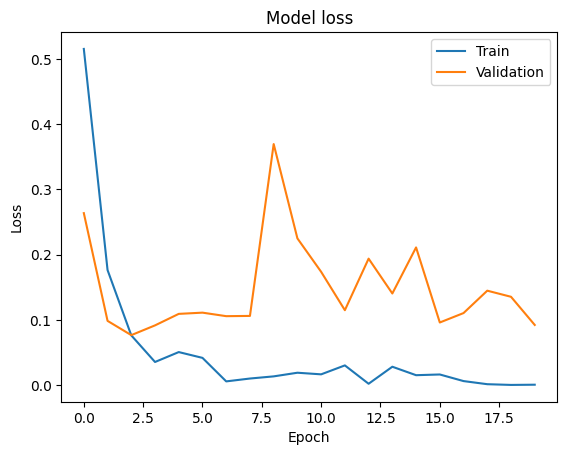

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("distilbert_weights/tf_model-epoch:{epoch:02d}-loss{val_loss:.2f}.h5", monitor="val_loss", verbose=0,
            save_best_only=True, save_weights_only=True, mode="auto", save_freq="epoch", options=None),
    tf.keras.callbacks.TensorBoard(log_dir=f"logs/fit/{datetime.now().strftime('%Y%m%d-%H%M%S')}", histogram_freq=1, write_graph=True)
]
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])
history = model.fit(train_dataset.shuffle(1).batch(16),
          epochs=20,
          batch_size=16,
          validation_data=val_dataset.shuffle(1).batch(16), 
          callbacks=callbacks)

# Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [13]:
model.save_pretrained("distilbert_weights/tf_model")